In [71]:
import math
import nltk
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# %pip install textblob
# %pip install vaderSentiment
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# https://towardsdatascience.com/text-analysis-feature-engineering-with-nlp-502d6ea9225d

analyser = SentimentIntensityAnalyzer()
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jexia\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [79]:
##### IMPORT AND CLEAN DATA

# train = pd.read_csv('/Users/mtjen/Desktop/313/project/train.csv')
train = pd.read_csv('train.csv')
train


# clean tweets
cleanedTweets = []

for index in range(len(train)):
#     tweet = train['text'][index]
#     cleaned = re.sub(r'[^\w\s]', '', str(tweet).lower().strip())
#     cleanedTweets.append(cleaned)
    cleanedTweets.append(train['text'][index])
    
train['cleanedTweets'] = cleanedTweets
train.drop(['text'], axis=1, inplace=True)

# Remove all non english words from tweets
# (trying to get rid of usernames and junk)

# import nltk
# # nltk.download('words')
# words = set(nltk.corpus.words.words())

# for tweet_index in range(len(train['cleanedTweets'])):
#     tweet = train.iloc[tweet_index]['cleanedTweets']
#     train.iat[tweet_index, 4] = " ".join(w for w in nltk.wordpunct_tokenize(tweet) if w.lower() in words or not w.isalpha())

# textblob sentiment
train["sentimentText"] = train['cleanedTweets'].apply(lambda x: 
                                                      TextBlob(x).sentiment.polarity)

# vader sentiment
train["sentimentVader"] = train['cleanedTweets'].apply(lambda x: 
                                                       analyser.polarity_scores(x)['compound'])

# move target to end
col = train.pop('target')
train['target'] = col

train

,id,keyword,location,cleanedTweets,sentimentText,sentimentVader,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,0.000000,0.2732,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,0.100000,-0.3400,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,-0.018750,-0.2960,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",0.000000,0.0000,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,0.000000,0.0000,1
...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,0.000000,-0.4939,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,0.150000,-0.5849,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,0.000000,0.0000,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,-0.260417,-0.7845,1


In [80]:
# Remove all data with no content in 'cleanedTweets'
# empty = np.where(train['cleanedTweets'] == '')
# print(empty)
# train.drop(train.index[empty], inplace=True, axis=0)
# train = train.assign(Index=range(len(train))).set_index('Index')
# print(train.shape)

In [81]:
charsToCheck = {'!', '@', '#', '?', '.', ',', 'http'}
vowels = {'a', 'e', 'i', 'o', 'u', 'A', 'E', 'I', 'O', 'U'}
nouns = {'NN', 'NNS', 'NNP', 'NNPS'}
verbs = {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'}
adj = {'JJ', 'JJR', 'JJS'}
adv = {'RR', 'RBR', 'RBS'}

hasLocation = []
hasKeyword = []
tweetNumberOfChars = []
specialCharacters = []
numberOfWords = []
avgCharsPerWord = []
numNumericTweet = []
numLettersTweet = []
numUpperTweet = []
numVowelsTweet = []
numConsonantsTweet = []
numNouns = []
numVerbs = []
numPrep = []
numAdj = []
numAdv = []

for index in range(len(train)):
    ##### location
    location = 0
    if pd.isnull(train['location'][index]) == False:
            location = 1
            
    ##### keyword
    keyword = 0
    if pd.isnull(train['keyword'][index]) == False:
            keyword = 1
    
    ###### tweet
    text = train['cleanedTweets'][index]
    # number of characters in twets
    numCharsTweet = len(text)
    
    # number of specific special characters in tweet
    specialChars = []
    for specialChar in charsToCheck:
        numSpecialChar = text.count(specialChar)
        specialChars.append(numSpecialChar)
    
    # average characters per word
    words = text.split()
    lenWords = []
    numNumeric = 0
    numLetters = 0
    numUpper = 0
    numVowels = 0
    numConsonants = 0
    
    nounNum = 0
    verbNum = 0
    prepNum = 0
    adjNum = 0
    advNum = 0
    
    ans = nltk.pos_tag(words)
    for pair in ans:
        wordType = pair[1]
        if wordType in nouns:
            nounNum += 1
        elif wordType in verbs:
            verbNum += 1
        elif wordType == 'IN':
            prepNum += 1
        elif wordType in adj:
            adjNum += 1
        elif wordType in adv:
            advNum += 1
    
    for word in words:
        wordLength = len(word)
        lenWords.append(wordLength)
        
        # number of letters/numbers, uppercase, vowels, consonants
        for char in word:
            if char.isnumeric():
                numNumeric += 1
            if char.isalpha():
                numLetters += 1
                if char.isupper():
                    numUpper += 1
                if char in vowels:
                    numVowels += 1
                else:
                    numConsonants += 1
        
    wordLengthAvg = np.mean(lenWords)
    
    # tweets with 1 word
    if math.isnan(wordLengthAvg):
        wordLengthAvg = 1
    
    # number of words
    numWords = len(words)
    
    hasLocation.append(location)
    hasKeyword.append(keyword)
    tweetNumberOfChars.append(numCharsTweet)
    specialCharacters.append(specialChars)
    numberOfWords.append(numWords)
    avgCharsPerWord.append(wordLengthAvg)
    numNumericTweet.append(numNumeric)
    numLettersTweet.append(numLetters)
    numUpperTweet.append(numUpper)
    numVowelsTweet.append(numVowels)
    numConsonantsTweet.append(numConsonants)
    numNouns.append(nounNum)
    numVerbs.append(verbNum)
    numPrep.append(prepNum)
    numAdj.append(adjNum)
    numAdv.append(advNum)

    
# specials
numEx = []
numAt = []
numHash = []
numQ = []
numPeriod = []
numComma = []
numLinks = []
numPunc = []

for tweetCharacters in specialCharacters:
    totalPunc = 0
    for index in range(len(charsToCheck)):
        value = tweetCharacters[index]
        totalPunc += value
        if index == 0:
            numEx.append(value)
        elif index == 1:
            numAt.append(value)
        elif index == 2:
            numHash.append(value)
        elif index == 3:
            numQ.append(value)
        elif index == 4:
            numPeriod.append(value)
        elif index == 5:
            numComma.append(value)
        elif index == 6:
            numLinks.append(value)
    numPunc.append(totalPunc)

In [82]:
# create new dataframe
colNames = ['hasLocation', 'hasKeyword', 'tweetNumberOfChars', 'numberOfWords', 'numEx', 
            'numAt', 'numHash', 'numQ', 'numPeriod', 'numComma', 'numLinks', 'numPunc',
            'avgCharsPerWord', 'numNumericTweet', 'numLettersTweet', 'numUpperTweet',
            'numVowelsTweet', 'numConsonantsTweet', 'numNouns', 'numVerbs', 'numPrep', 
            'numAdj', 'numAdv']
colValues = [hasLocation, hasKeyword, tweetNumberOfChars, numberOfWords, numEx, numAt, 
             numHash,numQ, numPeriod, numComma, numLinks, numPunc, avgCharsPerWord, 
             numNumericTweet, numLettersTweet, numUpperTweet, numVowelsTweet, 
             numConsonantsTweet, numNouns, numVerbs, numPrep, numAdj, numAdv]

data = pd.DataFrame()
for index in range(len(colNames)):
    colName = colNames[index]
    colVals = colValues[index]
    data[colName] = colVals

    
data['sentimentText'] = train['sentimentText']
data['sentimentVader'] = train['sentimentVader']
data['target'] = train['target']

data

,hasLocation,hasKeyword,tweetNumberOfChars,numberOfWords,numEx,numAt,numHash,numQ,numPeriod,numComma,...,numVowelsTweet,numConsonantsTweet,numNouns,numVerbs,numPrep,numAdj,numAdv,sentimentText,sentimentVader,target
0,0,0,69,13,0,0,0,0,1,0,...,25,31,6,1,1,0,0,0.000000,0.2732,1
1,0,0,38,7,0,0,0,0,0,0,...,13,18,6,0,1,0,0,0.100000,-0.3400,1
2,0,0,133,22,0,0,0,0,0,0,...,45,64,8,7,3,1,0,-0.018750,-0.2960,1
3,0,0,65,8,0,0,0,1,1,0,...,24,26,5,0,1,1,0,0.000000,0.0000,1
4,0,0,88,16,0,0,0,0,2,0,...,25,45,6,3,4,0,0,0.000000,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,83,11,0,0,0,0,0,1,...,20,47,4,2,1,2,0,0.000000,-0.4939,1
7609,0,0,125,20,0,0,2,0,0,0,...,39,62,8,0,4,4,0,0.150000,-0.5849,1
7610,0,0,65,8,0,1,0,0,0,1,...,12,26,7,0,1,0,0,0.000000,0.0000,1
7611,0,0,137,19,0,0,0,0,0,0,...,49,65,10,1,3,3,0,-0.260417,-0.7845,1


In [83]:
data.to_csv('data.csv')
print(np.where(data['numPeriod'] != 0))

(array([   0,    3,    4, ..., 7601, 7604, 7607], dtype=int64),)


<AxesSubplot:>

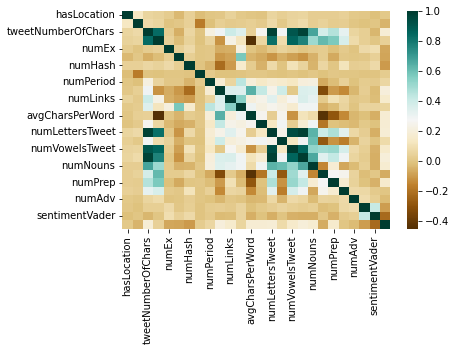

In [84]:
# Make heatmap to visualize
import seaborn as sns
sns.heatmap(data.corr(), cmap='BrBG')

In [85]:
# split to train and test data
trainData = data.sample(frac = 0.8, random_state = 25)
testData = data.drop(trainData.index)

stopIndex = data.shape[1] - 1

trainArray = trainData.values
trainX = trainArray[:,0:stopIndex]
trainY = trainArray[:,stopIndex]

testArray = testData.values
testX = testArray[:,0:stopIndex]
testY = testArray[:,stopIndex]

model = RandomForestClassifier()
model.fit(trainX, trainY)
model.score(testX, testY)

0.7347340774786605